In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
#!pip install spanda

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path

from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm
from sklearn.metrics import r2_score

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, Analytes, SpectraTfm, 
                                    TrimTfm, AnalytesTfm, SNVTfm, AvgTfm, GADFTfm, To3DTfm,
                                    ResizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
#device = torch.device('cuda:0' if use_cuda else 'cpu')
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

analyte_name = 725

## Training KSSL

In [ ]:
# Only samples with spectra
#path = Path('/root/kssl-mirs-v2'); path.ls()
path = Path('../../_data/kssl-mirs-v2'); path.ls()

(#46305) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

In [ ]:
# keep only when spectra in folder
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|███████████████████████████████████████████████████████| 46305/46305 [00:01<00:00, 26511.95it/s]

n samples: 46251


In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
# Only strictly positive measurements
paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

100%|████████████████████████████████████████████████████████| 46251/46251 [00:34<00:00, 1343.44it/s]

n samples: 44565


In [ ]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[AvgTfm, To3DTfm(1700),
                              LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=32, num_workers=6)
#dls.show_batch()

In [ ]:
dls.one_batch()[0][0].shape

torch.Size([3, 24, 24])

In [ ]:
#plt.imshow(dls.one_batch()[0][0].squeeze(), cmap='Spectral', 
#           origin='upper', extent=[4000,600,600,4000]);

In [ ]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=3).to_fp16()

In [ ]:
#learn.summary()

SuggestedLRs(valley=0.00015848931798245758)

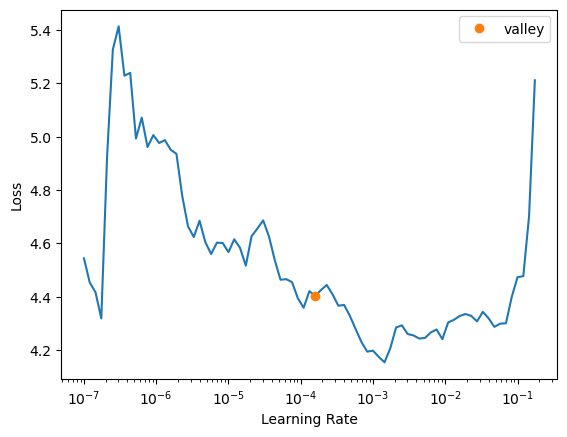

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 2e-4)

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,r2_score,time
0,1.486925,0.376037,-0.602930,10:59


/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,r2_score,time


KeyboardInterrupt: 

In [ ]:
#learn.save('xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323')

Path('models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth')

## Eval on MIRS seibsersdorf

In [ ]:
class cmolKgTfm(Transform):
    def __init__(self, 
                 atomW:float=39.098, # default is K's standard atomic weight
                ): 
        self.atomW = atomW 
        
    def encodes(self, ys:Analytes):
        return ys / self.atomW 

In [ ]:
def evaluate(model, dls):
    model.eval()
    y_hats = []
    y_trues = []
    for xb, yb in dls:
        y_hats.append(model(xb).detach().numpy())
        y_trues.append(yb.numpy())
    return (np.concatenate(y) for y in (y_hats, y_trues))

In [ ]:
path = Path('../../_data/seibersdorf-mirs')
paths = path.ls(); paths

(#176) [Path('../../_data/seibersdorf-mirs/135'),Path('../../_data/seibersdorf-mirs/95'),Path('../../_data/seibersdorf-mirs/66'),Path('../../_data/seibersdorf-mirs/104'),Path('../../_data/seibersdorf-mirs/68'),Path('../../_data/seibersdorf-mirs/103'),Path('../../_data/seibersdorf-mirs/168'),Path('../../_data/seibersdorf-mirs/157'),Path('../../_data/seibersdorf-mirs/150'),Path('../../_data/seibersdorf-mirs/159')...]

In [ ]:
# Loading seib. data
analyte = 'ex_k2o'

n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=[AvgTfm, TrimTfm, GADFTfm, ResizeTfm,
                              cmolKgTfm, LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=32, num_workers=6)
#dls.show_batch()

In [ ]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()
learn.path = Path('../../_data')
weights_paths = 'xresnet18-kex-mirs-kssl-10-epochs-gadf-07052023'
learn.load(weights_paths, device=device)

<fastai.learner.Learner>

In [ ]:
learn.summary()

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Sequential (Input shape: 32 x 1 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.0010000000474974513)

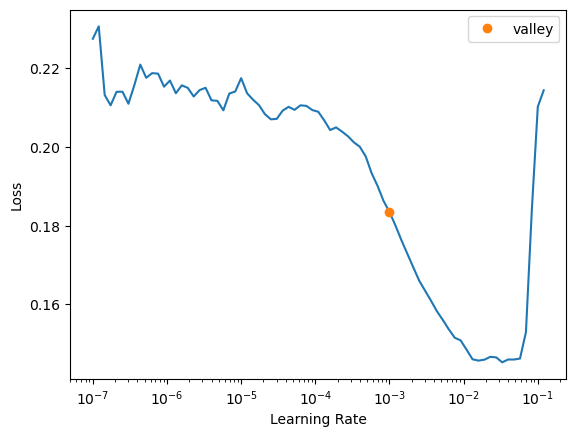

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 1e-5)

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,r2_score,time
0,0.249369,0.099288,-0.991501,00:14


/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,r2_score,time
0,0.255124,0.123158,-1.470264,00:19
1,0.245693,0.145354,-1.915468,00:19
2,0.239806,0.169562,-2.401020,00:20
3,0.234536,0.188534,-2.781571,00:19


KeyboardInterrupt: 

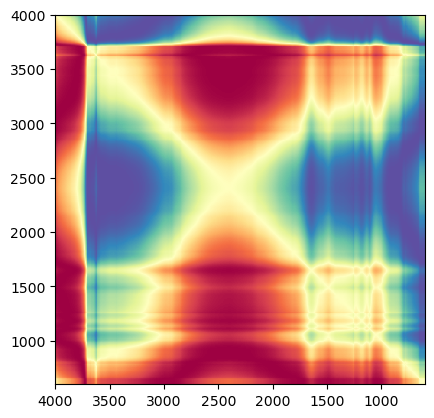

In [ ]:
plt.imshow(dls.one_batch()[0][0].squeeze(), cmap='Spectral', 
           origin='upper', extent=[4000,600,600,4000]);

r2:  -2.5348785065206534


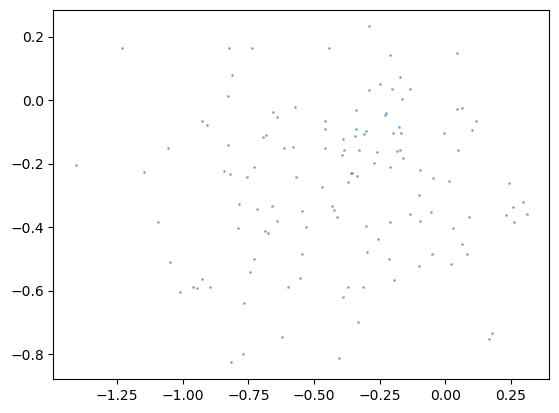

In [ ]:
y_hat, y_true = evaluate(learn.model, dls.train)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=1, alpha=0.5);

r2:  -2.914243271072757


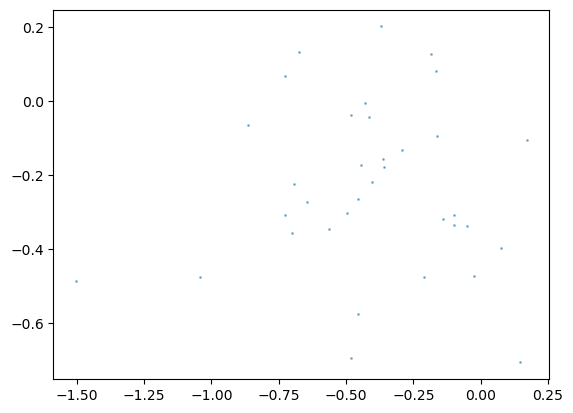

In [ ]:
y_hat, y_true = evaluate(learn.model, dls.valid)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=1, alpha=0.5);

In [ ]:
preds, targs = learn.get_preds(ds_idx=1)

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


## Eval on WCRC cross trial

In [ ]:
path_train = Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/train')
path_test = Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test')
paths = path_test.ls() + path_train.ls(); paths

(#59) [Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_14'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_13'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_49'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_47'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_55'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_06'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_01'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_26'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_04'),Path('../../_data/wcrc-ct-bundled/ETH_vertex/potassium_cmolkg/test/RT_35')...]

In [ ]:
# Loading seib. data
analyte = 'potassium_cmolkg'

n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[AvgTfm, GADFTfm, ResizeTfm,
                              LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=16, num_workers=6)
#dls.show_batch()

In [ ]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()
learn.path = Path('../../_data')
weights_paths = 'xresnet18-kex-mirs-kssl-10-epochs-gadf-07052023'
learn.load(weights_paths, device=device)

<fastai.learner.Learner>

In [ ]:
#learn.lr_find()

In [ ]:
learn.fine_tune(8, 2e-3)

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,r2_score,time
0,0.129026,0.076604,0.061117,00:05


/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,r2_score,time
0,0.102593,0.069820,0.144268,00:07
1,0.095558,0.059847,0.266496,00:07
2,0.076747,0.048947,0.400092,00:07
3,0.063577,0.044155,0.458825,00:07
4,0.052867,0.042665,0.477086,00:07
5,0.045024,0.042341,0.481051,00:07
6,0.038851,0.042303,0.481518,00:07
7,0.035100,0.042102,0.483981,00:07


r2:  0.9400578102344566


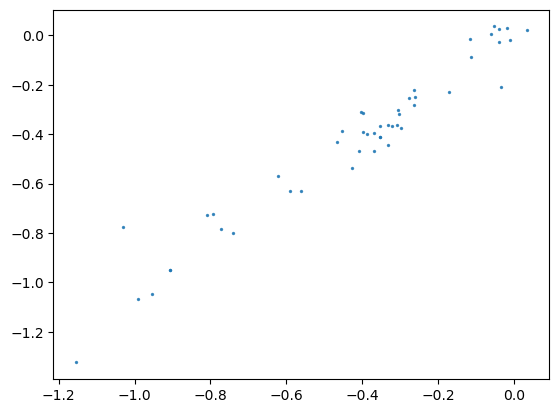

In [ ]:
y_hat, y_true = evaluate(learn.model, dls.train)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=2, alpha=0.8);

r2:  0.48398117932715


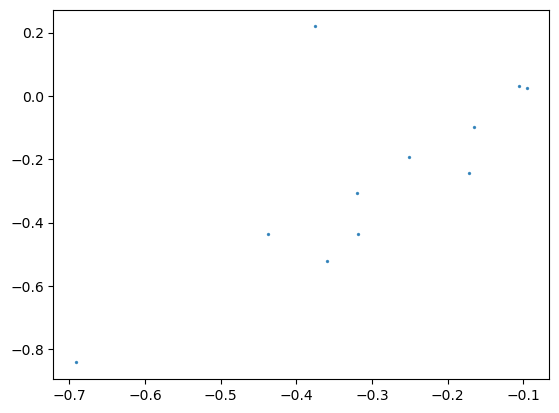

In [ ]:
y_hat, y_true = evaluate(learn.model, dls.valid)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=2, alpha=0.8);

In [ ]:
r2_score(targs, preds)

0.9116589481896179

In [ ]:
#learn.dls = dls

In [ ]:
#preds_seib, targs_seib = learn.get_preds(ds_idx=0)

## PLSR & Cubist

In [ ]:
def asTabular(dls, n=1):
    xs, ys = [], []
    for i in range(n):
        for x, y in tqdm(dls):
            xs.append(x)
            ys.append(y)
    return (torch.cat(ds).squeeze().numpy() for ds in (xs, ys))

In [ ]:
# Loading seib. data
analyte = 'potassium_cmolkg'

n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(valid_pct=0.2, seed=2),
                   item_tfms=[AvgTfm, SNVTfm,
                              LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=16, num_workers=6)
#dls.show_batch()

In [ ]:
(X_train, y_train) = asTabular(dls.train)

100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.95it/s]


In [ ]:
(X_valid, y_valid) = asTabular(dls.valid)

100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


In [ ]:
X_valid.shape

(11, 1700)

In [ ]:
# PLSR
from sklearn.cross_decomposition import PLSRegression

In [ ]:
for n in range(2,10):
    plsr = PLSRegression(n_components=n)
    plsr.fit(X_train, y_train)
    print(f'{n}: {r2_score(y_valid, plsr.predict(X_valid))}')

2: 0.9012730560352192
3: 0.9519736569968746
4: 0.9285342282616803
5: 0.8762250724937697
6: 0.9235713046295366
7: 0.8886260873863097
8: 0.8844774018855295
9: 0.8500554632351527


r2:  0.9519736569968746


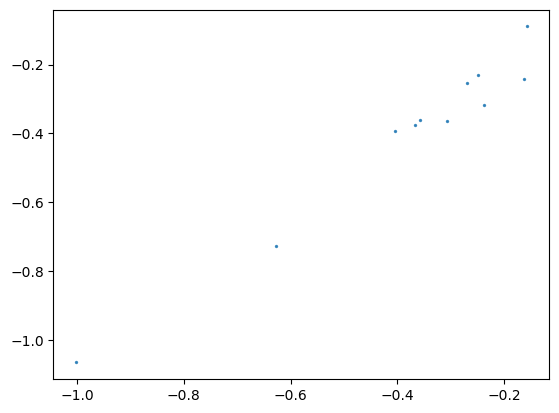

In [ ]:
plsr = PLSRegression(n_components=3)
plsr.fit(X_train, y_train)
y_hat = plsr.predict(X_valid)
print('r2: ', r2_score(y_valid, y_hat))
plt.scatter(y_hat, y_valid, s=2, alpha=0.8);

In [ ]:
from cubist import Cubist

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/cubist/_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(


r2:  0.8502139545891433


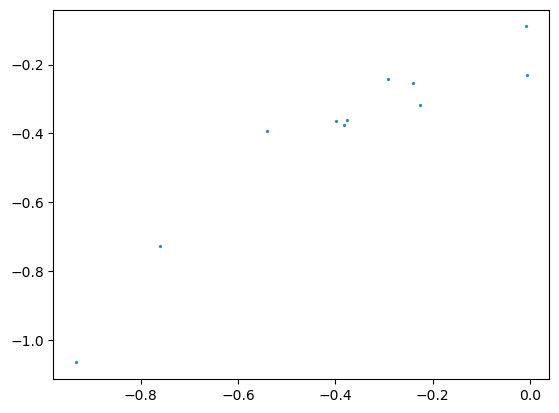

In [ ]:
model = Cubist(n_committees=20, neighbors=2, composite=True) # <- model parameters here
model.fit(X_train, y_train)
y_hat = model.predict(X_valid)

print('r2: ', r2_score(y_valid, y_hat))
plt.scatter(y_hat, y_valid, s=2, alpha=0.8);

In [ ]:
?Cubist

In [ ]:
#model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)

In [ ]:
# Load KSSL trained model
#weights_paths = '../../_data/models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth'
#weights_paths = '../../_data/models/xresnet18-kex-mirs-kssl-10-epochs-gadf-05052023.pth'

#xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
#model.load_state_dict(xresnet_dict['model'])